# Lung Cancer Detection

## Download Data

In [1]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/bhmdr45bh2-2.zip

--2021-06-13 13:39:43--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/bhmdr45bh2-2.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.0.240
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.0.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156614682 (149M) [application/octet-stream]
Saving to: ‘bhmdr45bh2-2.zip’

bhmdr45bh2-2.zip    100%[===================>] 149.36M  27.7MB/s    in 6.3s    

2021-06-13 13:39:50 (23.6 MB/s) - ‘bhmdr45bh2-2.zip’ saved [156614682/156614682]



## Extract Data

In [2]:
!unzip '/content/bhmdr45bh2-2.zip' -d '/tmp'

Archive:  /content/bhmdr45bh2-2.zip
  inflating: /tmp/The IQ-OTHNCCD lung cancer dataset.zip  


In [ ]:
!unzip '/tmp/The IQ-OTHNCCD lung cancer dataset.zip' -d '/tmp'

## Splitting Data

In [4]:
import os

try:
    os.makedirs("/tmp/lung-cancer/training/benign/")
    os.makedirs("/tmp/lung-cancer/testing/benign/")

    os.makedirs("/tmp/lung-cancer/training/malignant/")
    os.makedirs("/tmp/lung-cancer/testing/malignant/")

    os.makedirs("/tmp/lung-cancer/training/normal/")
    os.makedirs("/tmp/lung-cancer/testing/normal/")

except OSError:
    pass

In [5]:
import random
from shutil import copyfile

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    dir_content = random.sample(os.listdir(SOURCE), len(os.listdir(SOURCE)))
    train_size = int(len(dir_content) * SPLIT_SIZE)
    for i, image_name in enumerate(dir_content):
        if os.path.getsize(os.path.join(SOURCE, image_name)) > 0:
            if i < train_size:
                copyfile(os.path.join(SOURCE, image_name), os.path.join(TRAINING, image_name))
            else:
                copyfile(os.path.join(SOURCE, image_name), os.path.join(TESTING, image_name))

BENGIN_SOURCE_DIR = "/tmp/The IQ-OTHNCCD lung cancer dataset/Bengin cases"
TRAINING_BENGIN_DIR = "/tmp/lung-cancer/training/benign/"
TESTING_BENGIN_DIR = "/tmp/lung-cancer/testing/benign/"

MALIGNANT_SOURCE_DIR = "/tmp/The IQ-OTHNCCD lung cancer dataset/Malignant cases"
TRAINING_MALIGNANT_DIR = "/tmp/lung-cancer/training/malignant"
TESTING_MALIGNANT_DIR = "/tmp/lung-cancer/testing/malignant/"

NORMAL_SOURCE_DIR = "/tmp/The IQ-OTHNCCD lung cancer dataset/Normal cases"
TRAINING_NORMAL_DIR = "/tmp/lung-cancer/training/normal/"
TESTING_NORMAL_DIR = "/tmp/lung-cancer/testing/normal/"

split_size = .9
split_data(BENGIN_SOURCE_DIR, TRAINING_BENGIN_DIR, TESTING_BENGIN_DIR, split_size)
split_data(MALIGNANT_SOURCE_DIR, TRAINING_MALIGNANT_DIR, TESTING_MALIGNANT_DIR, split_size)
split_data(NORMAL_SOURCE_DIR, TRAINING_NORMAL_DIR, TESTING_NORMAL_DIR, split_size)

In [6]:
print(len(os.listdir('/tmp/lung-cancer/training/benign/')))
print(len(os.listdir('/tmp/lung-cancer/training/malignant/')))
print(len(os.listdir('/tmp/lung-cancer/training/normal/')))
print()
print(len(os.listdir('/tmp/lung-cancer/testing/benign/')))
print(len(os.listdir('/tmp/lung-cancer/testing/malignant/')))
print(len(os.listdir('/tmp/lung-cancer/testing/normal/')))

108
504
374

12
57
42


## Modeling with Xception

In [16]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

conv_base = Xception(include_top=False, input_shape=(150,150,3))

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block13_sepconv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

model = Sequential()
model.add(layers.Conv2D(3, (3,3), padding='same',
                        input_shape=(150,150,1)))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu',
                                kernel_regularizer=L2(0.01)))
model.add(layers.Dense(3, activation='softmax'))

optimizer= Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=[keras.metrics.Precision(name='precision'),
                        keras.metrics.Recall(name='recall'),
                        keras.metrics.AUC(name='auc'),
                        keras.metrics.CategoricalAccuracy(name='acc')]) 

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/tmp/lung-cancer/training/"
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    shear_range=.2,
    zoom_range=.2,
    fill_mode="nearest",
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150, 150),
    batch_size=10,
    class_mode="categorical",
    color_mode='grayscale',
)

VALIDATION_DIR = "/tmp/lung-cancer/testing/"
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150, 150),
    batch_size=10,
    class_mode="categorical",
    color_mode='grayscale',
)

Found 986 images belonging to 3 classes.
Found 111 images belonging to 3 classes.


In [18]:
class myCallback(tf.keras.callbacks.Callback):
  def __init__(self,
               desired_acc=0.5):
    self.desired_acc = desired_acc

  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc')>self.desired_acc):
      print(f"\nReached {self.desired_acc} accuracy so cancelling training!")
      self.model.stop_training = True

In [20]:
epochs = 100
callbacks = myCallback(0.98)
history = model.fit(train_generator,
                    epochs=100,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[callbacks])

Epoch 1/100
99/99 [==============================] - 18s 185ms/step - loss: 0.0518 - precision: 0.9858 - recall: 0.9848 - auc: 0.9994 - acc: 0.9858 - val_loss: 0.1041 - val_precision: 0.9640 - val_recall: 0.9640 - val_auc: 0.9976 - val_acc: 0.9640
Epoch 2/100
99/99 [==============================] - 18s 184ms/step - loss: 0.0595 - precision: 0.9828 - recall: 0.9828 - auc: 0.9993 - acc: 0.9828 - val_loss: 0.1359 - val_precision: 0.9459 - val_recall: 0.9459 - val_auc: 0.9904 - val_acc: 0.9459
Epoch 3/100
99/99 [==============================] - 18s 185ms/step - loss: 0.0708 - precision: 0.9848 - recall: 0.9848 - auc: 0.9993 - acc: 0.9848 - val_loss: 0.0696 - val_precision: 0.9730 - val_recall: 0.9730 - val_auc: 0.9992 - val_acc: 0.9730
Epoch 4/100
99/99 [==============================] - 18s 185ms/step - loss: 0.0422 - precision: 0.9899 - recall: 0.9899 - auc: 0.9997 - acc: 0.9899 - val_loss: 0.2414 - val_precision: 0.9099 - val_recall: 0.9099 - val_auc: 0.9887 - val_acc: 0.9099
Epoch 5/

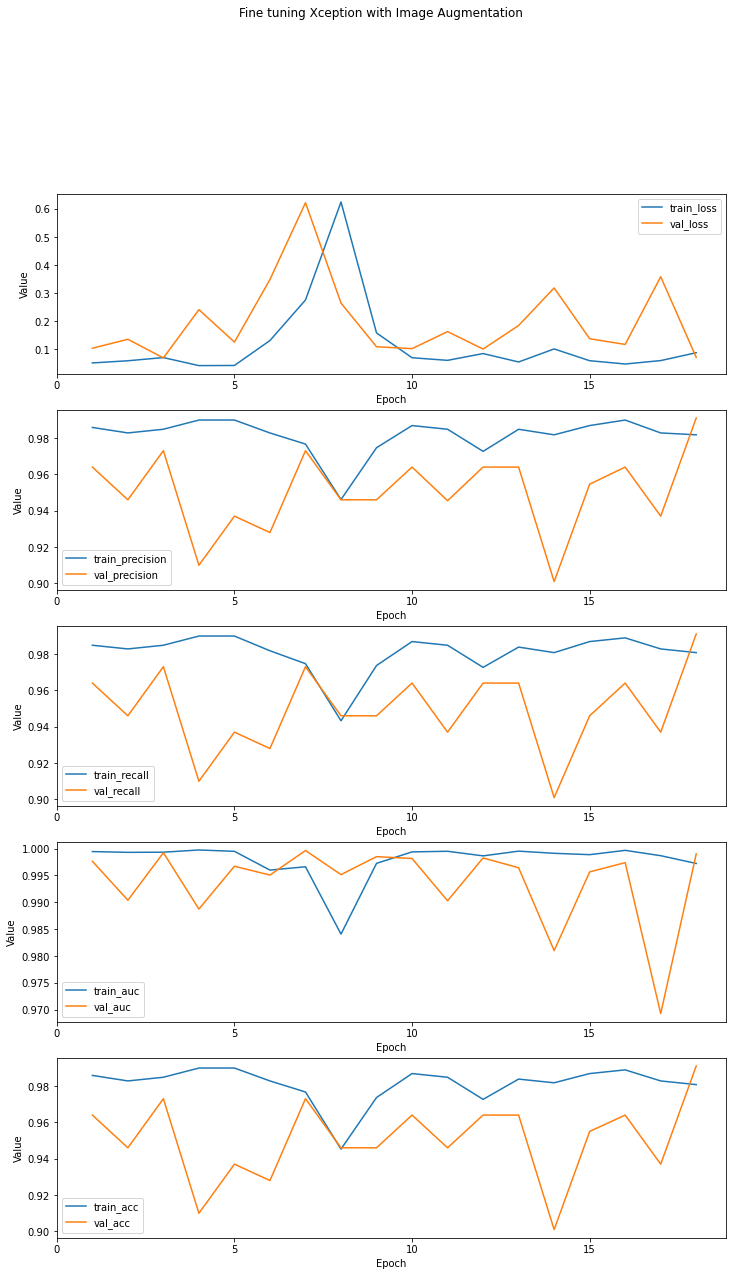

In [38]:
import matplotlib.pyplot as plt
import numpy as np
 
f, ax = plt.subplots(5, 1, figsize=(12, 20))
t = f.suptitle('Fine tuning Xception with Image Augmentation', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

keys = list(history.history.keys())
metrics = [(keys[i], keys[i+5]) for i in range(len(keys)//2)]

epochs = len(history.history['acc'])
epoch_list = list(range(1,epochs+1))
for i, (train, test) in enumerate(metrics):
  ax[i].plot(epoch_list, history.history[train], label=f'train_{train}')
  ax[i].plot(epoch_list, history.history[test], label=f'{test}')
  ax[i].set_xticks(np.arange(0, epochs, 5))
  ax[i].set_ylabel('Value')
  ax[i].set_xlabel('Epoch')
  ax[i].legend(loc="best")
